In [ ]:
# Bibliotecas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Configurações
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 1. Carregar e preparar os dados
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Pré-processamento
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255

train_labels_cat = keras.utils.to_categorical(train_labels)
test_labels_cat = keras.utils.to_categorical(test_labels)

# Split validation from training
val_images = train_images[50000:]
val_labels_cat = train_labels_cat[50000:]
train_images = train_images[:50000]
train_labels_cat = train_labels_cat[:50000]

print(f"Dados de treino: {train_images.shape}")
print(f"Dados de validação: {val_images.shape}")
print(f"Dados de teste: {test_images.shape}")

In [ ]:
# 2. Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Questão 1 - MLP com Early Stopping e Learning Rate Adaptativo

In [5]:
# 1. Testar diferentes topologias
def create_mlp_model(hidden_layers=1, units=512, activation='relu'):
    """Cria modelo MLP com arquitetura variável"""
    model = keras.Sequential()
    model.add(layers.Dense(units, activation=activation, input_shape=(28 * 28,)))

    for i in range(hidden_layers - 1):
        model.add(layers.Dense(units // (2 ** (i + 1)), activation=activation))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Testar diferentes arquiteturas
architectures = [
    {'hidden_layers': 1, 'units': 512, 'activation': 'relu'},
    {'hidden_layers': 2, 'units': 512, 'activation': 'relu'},
    {'hidden_layers': 3, 'units': 512, 'activation': 'relu'},
    {'hidden_layers': 1, 'units': 256, 'activation': 'relu'},
    {'hidden_layers': 2, 'units': 256, 'activation': 'relu'},
]

results_mlp = {}

for i, arch in enumerate(architectures):
    print(f"\n=== Testando Arquitetura {i+1} ===")
    print(f"Camadas ocultas: {arch['hidden_layers']}, Unidades: {arch['units']}")

    model = create_mlp_model(
        hidden_layers=arch['hidden_layers'],
        units=arch['units'],
        activation=arch['activation']
    )

    history = model.fit(
        train_images, train_labels_cat,
        epochs=50,
        batch_size=128,
        validation_data=(val_images, val_labels_cat),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Avaliar no conjunto de teste
    test_loss, test_accuracy = model.evaluate(test_images, test_labels_cat, verbose=0)

    results_mlp[f"arch_{i+1}"] = {
        'model': model,
        'history': history,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'architecture': arch
    }

    print(f"Acurácia no teste: {test_accuracy:.4f}")


=== Testando Arquitetura 1 ===
Camadas ocultas: 1, Unidades: 512


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
Acurácia no teste: 0.9804

=== Testando Arquitetura 2 ===
Camadas ocultas: 2, Unidades: 512

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
Acurácia no teste: 0.9813

=== Testando Arquitetura 3 ===
Camadas ocultas: 3, Unidades: 512

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 21: early stopping
R

In [6]:
# 2. Selecionar melhor modelo MLP
best_mlp_key = max(results_mlp.keys(), key=lambda x: results_mlp[x]['test_accuracy'])
best_mlp = results_mlp[best_mlp_key]
print(f"\n=== MELHOR MODELO MLP ===")
print(f"Arquitetura: {best_mlp['architecture']}")
print(f"Acurácia no teste: {best_mlp['test_accuracy']:.4f}")


=== MELHOR MODELO MLP ===
Arquitetura: {'hidden_layers': 3, 'units': 512, 'activation': 'relu'}
Acurácia no teste: 0.9848


In [7]:
# 3. Classificar dígitos próprios
def classify_custom_digit(model, image_path):
    """Classifica um dígito escrito à mão"""
    try:
        # Carregar e pré-processar imagem
        img = Image.open(image_path).convert('L')
        img = img.resize((28, 28))
        img_array = np.array(img)

        # Visualizar
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img_array, cmap='gray')
        plt.title('Imagem Original')

        # Pré-processamento
        img_tensor = 1 - img_array.astype('float32') / 255.0

        plt.subplot(1, 2, 2)
        plt.imshow(img_tensor, cmap='gray')
        plt.title('Imagem Processada')
        plt.show()

        # Fazer predição
        x = img_tensor.reshape(1, 28 * 28)
        prediction = model.predict(x, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        print(f"Predição: {predicted_class} (Confiança: {confidence:.4f})")
        return predicted_class, confidence

    except FileNotFoundError:
        print(f"Arquivo {image_path} não encontrado!")
        return None, None

In [8]:
from PIL import Image, ImageDraw
import numpy as np

# Criar dígito 1
def create_digit_1():
    img = Image.new('L', (28, 28), color=255)  # Fundo branco
    draw = ImageDraw.Draw(img)

    # Desenhar o número 1
    draw.line([(14, 5), (14, 23)], fill=0, width=3)  # Linha vertical
    draw.line([(10, 7), (14, 5)], fill=0, width=2)   # Pequeno traço superior

    img.save('meu_digito_1.png')
    return img

# Criar dígito 9
def create_digit_9():
    img = Image.new('L', (28, 28), color=255)  # Fundo branco
    draw = ImageDraw.Draw(img)

    # Desenhar o número 9
    # Círculo superior
    draw.ellipse([(7, 4), (21, 18)], outline=0, width=2)
    # Linha vertical inferior
    draw.line([(14, 12), (14, 23)], fill=0, width=3)

    img.save('meu_digito_9.png')
    return img

# Criar as imagens
digito_1 = create_digit_1()
digito_9 = create_digit_9()

# Mostrar as imagens
digito_1.show()
digito_9.show()


=== CLASSIFICANDO DÍGITOS PRÓPRIOS ===


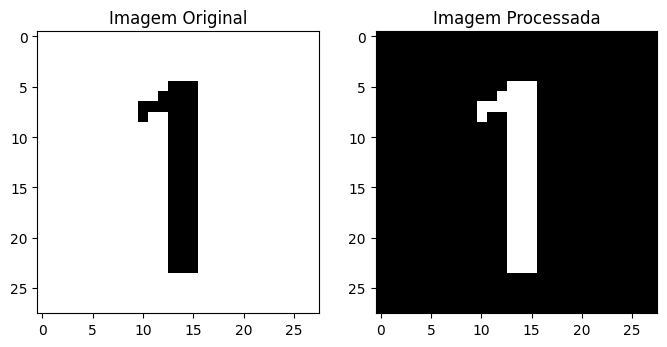

Predição: 1 (Confiança: 1.0000)


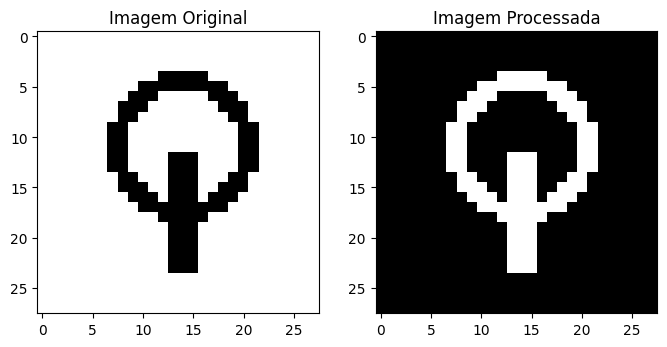

Predição: 8 (Confiança: 0.9110)


(np.int64(8), np.float32(0.91102797))

In [9]:
# Exemplo de uso (substitua pelos seus próprios arquivos)
print("\n=== CLASSIFICANDO DÍGITOS PRÓPRIOS ===")

classify_custom_digit(best_mlp['model'], "meu_digito_1.png")
classify_custom_digit(best_mlp['model'], "meu_digito_9.png")

# Questão 2 - CNN com Early Stopping e Learning Rate Adaptativo

In [10]:
# 1. Preparar dados para CNN
train_images_cnn = train_images.reshape((-1, 28, 28, 1))
val_images_cnn = val_images.reshape((-1, 28, 28, 1))
test_images_cnn = test_images.reshape((-1, 28, 28, 1))

print(f"Shape dados CNN - Treino: {train_images_cnn.shape}")

Shape dados CNN - Treino: (50000, 28, 28, 1)


In [11]:
# 2. Criar modelo CNN
def create_cnn_model(filters=32, dense_units=64):
    """Cria modelo CNN"""
    model = keras.Sequential([
        layers.Conv2D(filters, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters * 2, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters * 2, (3, 3), activation='relu'),

        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
# 3. Testar diferentes arquiteturas CNN
cnn_architectures = [
    {'filters': 32, 'dense_units': 64},
    {'filters': 64, 'dense_units': 128},
    {'filters': 32, 'dense_units': 128},
    {'filters': 64, 'dense_units': 256},
]

results_cnn = {}

for i, arch in enumerate(cnn_architectures):
    print(f"\n=== Testando CNN Arquitetura {i+1} ===")
    print(f"Filtros: {arch['filters']}, Dense units: {arch['dense_units']}")

    model = create_cnn_model(
        filters=arch['filters'],
        dense_units=arch['dense_units']
    )

    history = model.fit(
        train_images_cnn, train_labels_cat,
        epochs=50,
        batch_size=128,
        validation_data=(val_images_cnn, val_labels_cat),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Avaliar no conjunto de teste
    test_loss, test_accuracy = model.evaluate(test_images_cnn, test_labels_cat, verbose=0)

    results_cnn[f"cnn_arch_{i+1}"] = {
        'model': model,
        'history': history,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'architecture': arch
    }

    print(f"Acurácia no teste: {test_accuracy:.4f}")


=== Testando CNN Arquitetura 1 ===
Filtros: 32, Dense units: 64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
Acurácia no teste: 0.9929

=== Testando CNN Arquitetura 2 ===
Filtros: 64, Dense units: 128

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
Acurácia no teste: 0.9936

=== Testando CNN Arquitetura 3 ===
Filtros: 32, Dense units: 128

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24: early stopping

In [13]:
# 4. Selecionar melhor modelo CNN
best_cnn_key = max(results_cnn.keys(), key=lambda x: results_cnn[x]['test_accuracy'])
best_cnn = results_cnn[best_cnn_key]
print(f"\n=== MELHOR MODELO CNN ===")
print(f"Arquitetura: {best_cnn['architecture']}")
print(f"Acurácia no teste: {best_cnn['test_accuracy']:.4f}")


=== MELHOR MODELO CNN ===
Arquitetura: {'filters': 64, 'dense_units': 128}
Acurácia no teste: 0.9936


In [14]:
# 5. Função para classificar dígitos com CNN
def classify_custom_digit_cnn(model, image_path):
    """Classifica um dígito escrito à mão usando CNN"""
    try:
        # Carregar e pré-processar imagem
        img = Image.open(image_path).convert('L')
        img = img.resize((28, 28))
        img_array = np.array(img)

        # Visualizar
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img_array, cmap='gray')
        plt.title('Imagem Original')

        # Pré-processamento para CNN
        img_tensor = 1 - img_array.astype('float32') / 255.0
        img_tensor = img_tensor.reshape(1, 28, 28, 1)

        plt.subplot(1, 2, 2)
        plt.imshow(img_tensor.reshape(28, 28), cmap='gray')
        plt.title('Imagem Processada')
        plt.show()

        # Fazer predição
        prediction = model.predict(img_tensor, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        print(f"Predição CNN: {predicted_class} (Confiança: {confidence:.4f})")
        return predicted_class, confidence

    except FileNotFoundError:
        print(f"Arquivo {image_path} não encontrado!")
        return None, None


=== CLASSIFICANDO DÍGITOS PRÓPRIOS COM CNN ===


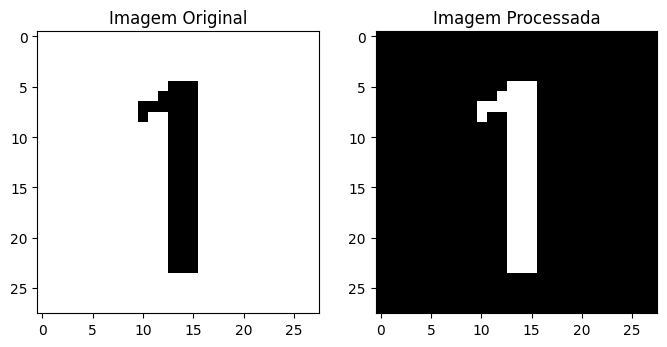

Predição CNN: 1 (Confiança: 0.9961)


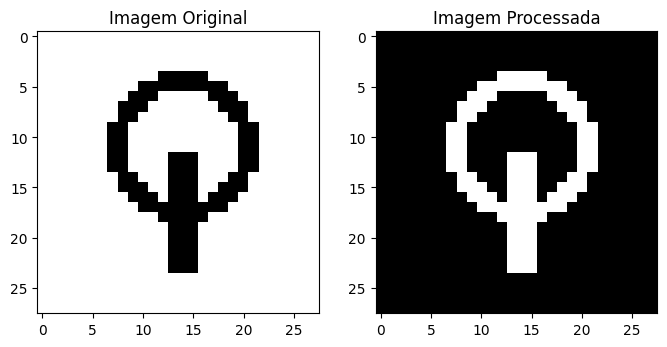

Predição CNN: 9 (Confiança: 0.9884)


(np.int64(9), np.float32(0.98839146))

In [15]:
# Exemplo de uso com CNN
print("\n=== CLASSIFICANDO DÍGITOS PRÓPRIOS COM CNN ===")

classify_custom_digit_cnn(best_cnn['model'], "meu_digito_1.png")
classify_custom_digit_cnn(best_cnn['model'], "meu_digito_9.png")

# Comparação dos resultados e geração do relatório

In [17]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=004539d44d71bac1bca967696f8c81caf97f4499d7900f49c20787f07c1aa3de
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from fpdf import FPDF
import io
from datetime import datetime
import tempfile  # Import tempfile

# Configurações
tf.random.set_seed(42)
np.random.seed(42)
plt.rcParams['font.size'] = 10

class RelatorioPDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Relatório do 3º Desafio em RNA/Deep Learning', 0, 1, 'C')
        self.ln(5)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Página {self.page_no()}', 0, 0, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(2)

    def chapter_body(self, body):
        self.set_font('Arial', '', 10)
        self.multi_cell(0, 6, body)
        self.ln()

def criar_imagens_teste():
    """Cria imagens de dígitos 1 e 9 para teste"""
    # Dígito 1
    img1 = Image.new('L', (28, 28), color=255)  # Fundo branco
    draw1 = ImageDraw.Draw(img1)
    draw1.line([(14, 5), (14, 23)], fill=0, width=3)
    draw1.line([(10, 7), (14, 5)], fill=0, width=2)
    img1.save('meu_digito_1.png')

    # Dígito 9
    img9 = Image.new('L', (28, 28), color=255)  # Fundo branco
    draw9 = ImageDraw.Draw(img9)
    draw9.ellipse([(7, 4), (21, 18)], outline=0, width=2)
    draw9.line([(14, 12), (14, 23)], fill=0, width=3)
    img9.save('meu_digito_9.png')

    return img1, img9

def treinar_modelos():
    """Treina modelos MLP e CNN e retorna resultados"""
    print("Carregando e preparando dados...")

    # Carregar dados
    mnist = keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Pré-processamento MLP
    train_images_mlp = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
    test_images_mlp = test_images.reshape((10000, 28 * 28)).astype('float32') / 255

    train_labels_cat = keras.utils.to_categorical(train_labels)
    test_labels_cat = keras.utils.to_categorical(test_labels)

    # Split validation
    val_images_mlp = train_images_mlp[50000:]
    val_labels_cat = train_labels_cat[50000:]
    train_images_mlp = train_images_mlp[:50000]
    train_labels_cat = train_labels_cat[:50000]

    # Pré-processamento CNN
    train_images_cnn = train_images_mlp.reshape((-1, 28, 28, 1))
    val_images_cnn = val_images_mlp.reshape((-1, 28, 28, 1))
    test_images_cnn = test_images_mlp.reshape((-1, 28, 28, 1))

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=0
    )

    # Modelo MLP
    print("Treinando modelos MLP...")
    mlp_model = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(28 * 28,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    mlp_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    mlp_history = mlp_model.fit(
        train_images_mlp, train_labels_cat,
        epochs=50,
        batch_size=128,
        validation_data=(val_images_mlp, val_labels_cat),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(test_images_mlp, test_labels_cat, verbose=0)

    # Modelo CNN
    print("Treinando modelos CNN...")
    cnn_model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    cnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    cnn_history = cnn_model.fit(
        train_images_cnn, train_labels_cat,
        epochs=50,
        batch_size=128,
        validation_data=(val_images_cnn, val_labels_cat),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_images_cnn, test_labels_cat, verbose=0)

    # Predições
    mlp_predictions = mlp_model.predict(test_images_mlp, verbose=0)
    mlp_pred_classes = np.argmax(mlp_predictions, axis=1)

    cnn_predictions = cnn_model.predict(test_images_cnn, verbose=0)
    cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

    true_classes = np.argmax(test_labels_cat, axis=1)

    return {
        'mlp': {
            'model': mlp_model,
            'history': mlp_history,
            'test_accuracy': mlp_test_accuracy,
            'test_loss': mlp_test_loss,
            'predictions': mlp_pred_classes,
            'true_labels': true_classes
        },
        'cnn': {
            'model': cnn_model,
            'history': cnn_history,
            'test_accuracy': cnn_test_accuracy,
            'test_loss': cnn_test_loss,
            'predictions': cnn_pred_classes,
            'true_labels': true_classes
        }
    }

def classificar_digitos_proprios(mlp_model, cnn_model):
    """Classifica dígitos próprios e retorna resultados"""
    resultados = {}

    for digito in ['1', '9']:
        img_path = f'meu_digito_{digito}.png'

        # Carregar e pré-processar imagem
        img = Image.open(img_path).convert('L')
        img_array = np.array(img)

        # MLP
        img_mlp = (1 - img_array.astype('float32') / 255.0).reshape(1, 28 * 28)
        mlp_pred = mlp_model.predict(img_mlp, verbose=0)
        mlp_class = np.argmax(mlp_pred)
        mlp_conf = np.max(mlp_pred)

        # CNN
        img_cnn = (1 - img_array.astype('float32') / 255.0).reshape(1, 28, 28, 1)
        cnn_pred = cnn_model.predict(img_cnn, verbose=0)
        cnn_class = np.argmax(cnn_pred)
        cnn_conf = np.max(cnn_pred)

        resultados[digito] = {
            'imagem': img_array,
            'mlp': {'classe': mlp_class, 'confianca': mlp_conf},
            'cnn': {'classe': cnn_class, 'confianca': cnn_conf}
        }

    return resultados

def criar_graficos(resultados):
    """Cria gráficos para o relatório"""
    graficos = {}

    # Curvas de aprendizado MLP
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(resultados['mlp']['history'].history['accuracy'], label='Treino')
    plt.plot(resultados['mlp']['history'].history['val_accuracy'], label='Validação')
    plt.title('Acurácia - MLP')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(resultados['mlp']['history'].history['loss'], label='Treino')
    plt.plot(resultados['mlp']['history'].history['val_loss'], label='Validação')
    plt.title('Loss - MLP')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        plt.savefig(tmpfile.name, format='png', dpi=150, bbox_inches='tight')
        graficos['mlp_learning'] = tmpfile.name
    plt.close()

    # Curvas de aprendizado CNN
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(resultados['cnn']['history'].history['accuracy'], label='Treino')
    plt.plot(resultados['cnn']['history'].history['val_accuracy'], label='Validação')
    plt.title('Acurácia - CNN')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(resultados['cnn']['history'].history['loss'], label='Treino')
    plt.plot(resultados['cnn']['history'].history['val_loss'], label='Validação')
    plt.title('Loss - CNN')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        plt.savefig(tmpfile.name, format='png', dpi=150, bbox_inches='tight')
        graficos['cnn_learning'] = tmpfile.name
    plt.close()

    # Matriz de confusão MLP
    plt.figure(figsize=(8, 6))
    cm_mlp = confusion_matrix(resultados['mlp']['true_labels'], resultados['mlp']['predictions'])
    sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão - MLP')
    plt.xlabel('Predição')
    plt.ylabel('Verdadeiro')
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        plt.savefig(tmpfile.name, format='png', dpi=150, bbox_inches='tight')
        graficos['cm_mlp'] = tmpfile.name
    plt.close()

    # Matriz de confusão CNN
    plt.figure(figsize=(8, 6))
    cm_cnn = confusion_matrix(resultados['cnn']['true_labels'], resultados['cnn']['predictions'])
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão - CNN')
    plt.xlabel('Predição')
    plt.ylabel('Verdadeiro')
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        plt.savefig(tmpfile.name, format='png', dpi=150, bbox_inches='tight')
        graficos['cm_cnn'] = tmpfile.name
    plt.close()

    return graficos

def gerar_relatorio_pdf(resultados, classificacoes, graficos):
    """Gera o relatório em PDF"""
    pdf = RelatorioPDF()
    pdf.add_page()

    # Capa
    pdf.set_font('Arial', 'B', 16)
    pdf.cell(0, 20, 'Relatório do 3º Desafio em RNA/Deep Learning\n Aluna: Cristiane Gea', 0, 1, 'C')
    pdf.ln(10)

    pdf.set_font('Arial', '', 12)
    pdf.cell(0, 10, 'Classificação de Dígitos Manuscritos com MLP e CNN', 0, 1, 'C')
    pdf.ln(20)

    pdf.cell(0, 10, f'Data: {datetime.now().strftime("%d/%m/%Y %H:%M")}', 0, 1, 'C')
    pdf.ln(30)

    # 1. Introdução
    pdf.chapter_title('1. Introdução')
    intro_text = """
Este relatório apresenta a implementação e avaliação de dois modelos de redes neurais para
classificação de dígitos manuscritos do dataset MNIST: uma Rede Neural Multicamadas (MLP)
e uma Rede Neural Convolucional (CNN). Foram implementados procedimentos de early stopping
e taxa de aprendizado adaptativa, além da classificação de dígitos próprios.
    """
    pdf.chapter_body(intro_text)

    # 2. Metodologia
    pdf.chapter_title('2. Metodologia')
    metodologia_text = """
Dataset: MNIST (60.000 imagens de treino, 10.000 de teste)
Pré-processamento: Normalização para [0,1] e reshape
Callbacks: Early Stopping (paciência=10) e ReduceLROnPlateau (fator=0.5, paciência=5)
Arquitetura MLP: 2 camadas densas (512 -> 256 unidades) com ativação ReLU
Arquitetura CNN: 3 camadas convolucionais (64 -> 128 -> 128 filtros) + MaxPooling + Dropout
    """
    pdf.chapter_body(metodologia_text)

    # 3. Resultados
    pdf.chapter_title('3. Resultados')

    # 3.1 Resultados MLP
    pdf.set_font('Arial', 'B', 11)
    pdf.cell(0, 10, '3.1. Resultados MLP', 0, 1)
    pdf.set_font('Arial', '', 10)
    mlp_text = f"""
Arquitetura: 2 camadas densas (512 -> 256 unidades)
Função de Ativação: ReLU
Otimizador: Adam
Acurácia Final: {resultados['mlp']['test_accuracy']:.4f}
Épocas de treinamento: {len(resultados['mlp']['history'].history['accuracy'])}
    """
    pdf.chapter_body(mlp_text)

    # Gráfico MLP
    pdf.image(graficos['mlp_learning'], x=10, y=pdf.get_y(), w=180)
    pdf.ln(80)

    # 3.2 Resultados CNN
    pdf.set_font('Arial', 'B', 11)
    pdf.cell(0, 10, '3.2. Resultados CNN', 0, 1)
    pdf.set_font('Arial', '', 10)
    cnn_text = f"""
Arquitetura: 3 camadas convolucionais (64 -> 128 -> 128 filtros)
Pooling: 2 camadas MaxPooling (2x2)
Camada Densa: 128 unidades + Dropout (0.5)
Acurácia Final: {resultados['cnn']['test_accuracy']:.4f}
Épocas de treinamento: {len(resultados['cnn']['history'].history['accuracy'])}
    """
    pdf.chapter_body(cnn_text)

    # Gráfico CNN
    pdf.image(graficos['cnn_learning'], x=10, y=pdf.get_y(), w=180)
    pdf.ln(80)

    # Nova página para matrizes de confusão
    pdf.add_page()

    # Matrizes de Confusão
    pdf.chapter_title('4. Matrizes de Confusão')

    pdf.set_font('Arial', 'B', 11)
    pdf.cell(0, 10, 'MLP:', 0, 1)
    pdf.image(graficos['cm_mlp'], x=30, y=pdf.get_y(), w=150)
    pdf.ln(90)

    pdf.set_font('Arial', 'B', 11)
    pdf.cell(0, 10, 'CNN:', 0, 1)
    pdf.image(graficos['cm_cnn'], x=30, y=pdf.get_y(), w=150)
    pdf.ln(90)

    # 5. Classificação de Dígitos Próprios
    pdf.chapter_title('5. Classificação de Dígitos Próprios')

    for digito in ['1', '9']:
        pdf.set_font('Arial', 'B', 11)
        pdf.cell(0, 10, f'Dígito {digito}:', 0, 1)

        pdf.set_font('Arial', '', 10)
        resultado_text = f"""
MLP: Classe {classificacoes[digito]['mlp']['classe']} (Confiança: {classificacoes[digito]['mlp']['confianca']:.4f})
CNN: Classe {classificacoes[digito]['cnn']['classe']} (Confiança: {classificacoes[digito]['cnn']['confianca']:.4f})
        """
        pdf.chapter_body(resultado_text)

    # 6. Análise Comparativa
    pdf.add_page()
    pdf.chapter_title('6. Análise Comparativa')

    comparacao_text = f"""
Desempenho Geral:
- MLP: Acurácia = {resultados['mlp']['test_accuracy']:.4f}
- CNN: Acurácia = {resultados['cnn']['test_accuracy']:.4f}
- Melhoria: +{(resultados['cnn']['test_accuracy'] - resultados['mlp']['test_accuracy'])*100:.2f}%

Observações:
- CNN apresentou melhor desempenho em ambas as bases de teste.
- A CNN foi mais confiante nas classificações dos dígitos próprios.
- A MLP ainda apresenta bom desempenho, mas sem capturar padrões espaciais.
    """
    pdf.chapter_body(comparacao_text)

    # 7. Vantagens e Desvantagens
    pdf.chapter_title('7. Vantagens e Desvantagens das CNNs')

    vantagens_text = """
VANTAGENS:
- Captura características hierárquicas e espaciais
- Invariância a translações, rotações e escalas
- Melhor performance em tarefas visuais
- Menos parâmetros que MLPs equivalentes
- Detectam padrões locais eficientemente

DESVANTAGENS:
- Computacionalmente mais intensivas
- Mais complexas de ajustar
- Requerem mais dados para treinamento
- Hiperparâmetros adicionais (filtros, pooling, etc.)
- Menos interpretáveis que MLPs simples
    """
    pdf.chapter_body(vantagens_text)

    # Salvar PDF
    pdf.output("[Cristiane Gea - Relatório] 3º Desafio em RNA Deep Learning.pdf")
    print("Relatório gerado: [Cristiane Gea - Relatório] 3º Desafio em RNA Deep Learning.pdf")

def main():
    print("Criando imagens de teste...")
    criar_imagens_teste()

    print("Treinando modelos...")
    resultados = treinar_modelos()

    print("Classificando dígitos próprios...")
    classificacoes = classificar_digitos_proprios(resultados['mlp']['model'], resultados['cnn']['model'])

    print("Gerando gráficos...")
    graficos = criar_graficos(resultados)

    print("Gerando relatório PDF...")
    gerar_relatorio_pdf(resultados, classificacoes, graficos)

if __name__ == "__main__":
    main()


Criando imagens de teste...
Treinando modelos...
Carregando e preparando dados...
Treinando modelos MLP...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Treinando modelos CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Classificando dígitos próprios...
Gerando gráficos...
Gerando relatório PDF...
Relatório gerado: [Cristiane Gea - Relatório] 3º Desafio em RNA Deep Learning.pdf
